In [312]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors


from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *

from scipy.optimize import root, curve_fit, least_squares
from scipy.interpolate import interp1d
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from exp_setup import Cylindrical_Grid, Experiment, Measurements
# from TTM_solver import TwoTemperatureModel
from Hydro_solver import HydroModel

import cProfile

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [35]:
grid  = Cylindrical_Grid(200e-6, N=200) 
Z, A = 54, 131
Te_initial, Ti_initial = 26.4e3, 0#20.6e3, 0#16.60952380952381e3, 9.32e3 #[K]
temperature_measurement_width = 20e-6 # [m]
gaussian_FWHM = 124.3e-6 #105.2e-6
n0 = 1.25e20 *1e6

dih_file = "/home/zach/plasma/TTM/data/Xe5bar_DIH_profile_data.txt"


# Create Experimental layout and TTM solver
Xenon_jt = Experiment(grid, n0, Z, A, Te_initial, Ti_initial, gaussian_FWHM, temperature_measurement_width,
                      gas_name='Xenon', model = "SMT", ion_temperature_model = 'MD',
                      ion_temperature_file=dih_file, electron_temperature_model='gaussian', 
                      Te_experiment_is_peak=True, super_gaussian_power=0.5)

ttm = HydroModel(Xenon_jt, model = "SMT")

# Xenon_smt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Xenon', model = "SMT",
#                       ion_temperature_model = 'gaussian', ion_temperature_file = dih_file)
# ttm_smt = TwoTemperatureModel(Xenon_smt, model = "SMT")

Te_max = 2.640e+04 K


# Fit Initial Conditions
Gaussian: Te = 20.6 kK, FWHM = 105.2 μm

SuperGaussian (n=2): Te = 19.5 kK, FWHM = 84.3 μm

SuperGaussian (n=0.5): Te = ? kK, FWHM = ? μm


In [36]:
Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)
Xe_FWHM_data = read_csv("./data/experimental_data/Xe_5bar_FWHM.txt", delim_whitespace=True, header=1)

exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 100e-6, Nx = 1000, Nz=100)
print("Exp: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(Xe_FWHM_data['FWHM[μm]'][0], Xe_data['T[kK]'][0]))
print("Sim: FWHM = {0:.2f} [μm], Te = {1:.2f} [kK]".format(exp_i.FWHM*1e6,exp_i.Te_fit/1e3))

/home/zach/plasma/TTM/physics.py:300: RuntimeWarning: invalid value encountered in sqrt
  l_mfp = c/ν_ω * np.sqrt(1-γ)/γ


Exp: FWHM = 51.18 [μm], Te = 16.61 [kK]
Sim: FWHM = 51.05 [μm], Te = 16.61 [kK]


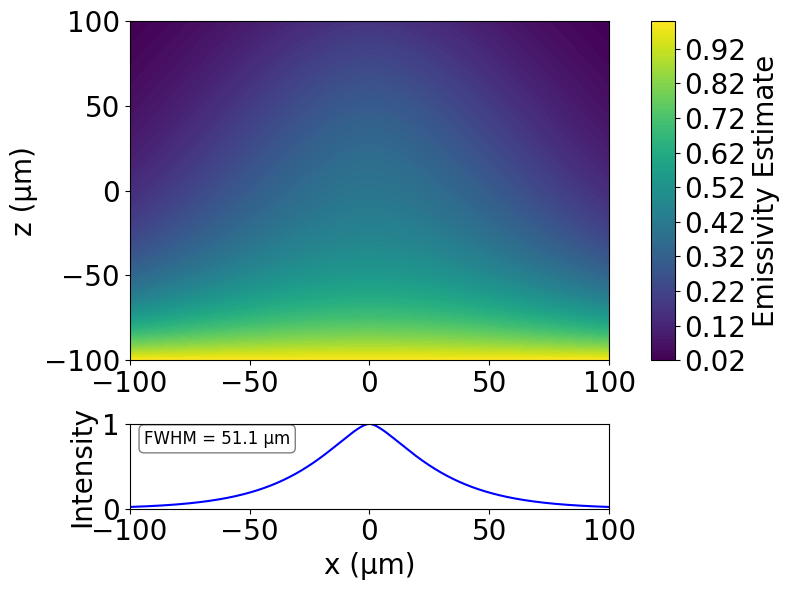

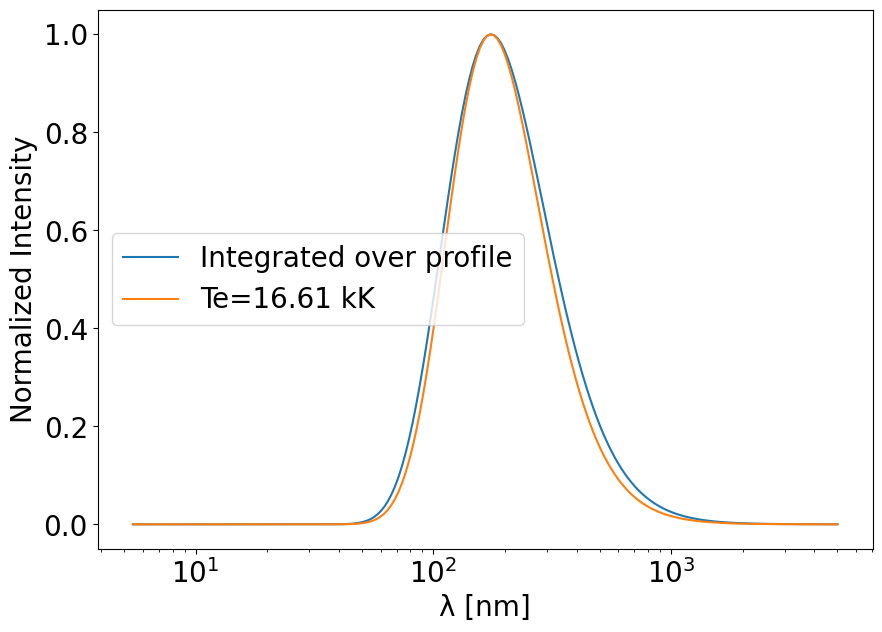

In [37]:
exp_i.plot_emissivity_and_intensity(exp_i.I_unnormalized_of_r)
exp_i.plot_spectral_Intensity()

# Run Sim

In [38]:
%%time
ttm.solve_hydro(tmax=18e-9, dt=1e-11)

CPU times: user 1min 28s, sys: 21.9 ms, total: 1min 28s
Wall time: 1min 28s


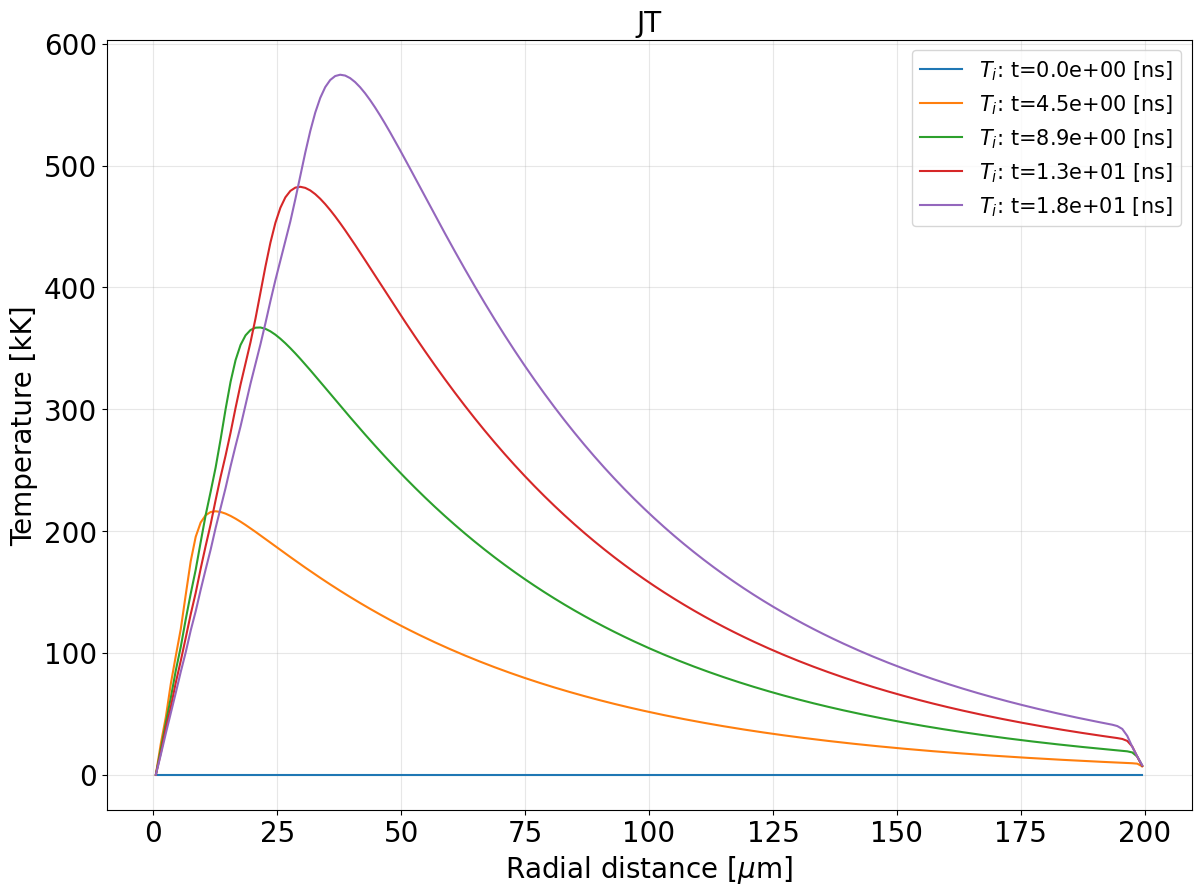

In [39]:
def plot_temp_profiles(ttm, plot_times = None, ax = None, title='', normalized=False):

    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_saved_list)*0.99,num=5,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    
        
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm.t_saved_list[ti]
        if normalized==True:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]/ttm.Te_list[ti][0], '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]/ttm.Ti_list[ti][0], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
        else:
#             ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.v_list[ti][:-1], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.n__list[ti][:-1])/(ttm.n_i_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Te_list[ti][1:])-(ttm.Te_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Ti_list[ti][1:])-(ttm.Ti_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            
        # plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
#     ax.set_xlim(55,85)
#     ax.set_ylim(0,3)
#     ax.set_yscale('log')
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)
    ax.set_title(title, fontsize=20)

    
fig, ax = plt.subplots(1,1, figsize=(14,10),facecolor='w')
ax = np.array([ax])
plot_temp_profiles(ttm, ax = ax[0], title='JT', normalized=False, plot_times=None)#[12,13,14])


# Get Intensity From Absorption Integral over Line of Sight

### See Initial Condition

In [40]:
%%time
i=0
cproexp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 1000, Nz=100)
print("t:{0:.2f} [ns], T_e = {1:.2f} [kK], FWHM = {2:.2f} [µm]".format(ttm.t_saved_list[i]*1e9, float(exp_i.Te_fit)/1e3, exp_i.FWHM*1e6))

t:0.00 [ns], T_e = 16.61 [kK], FWHM = 51.05 [µm]
CPU times: user 5.7 s, sys: 2.87 s, total: 8.57 s
Wall time: 8.61 s


### All times 

In [47]:
%%time
FWHM_list = []
FWHM_indices = list(set(list(range(5)) + list(range(len(ttm.t_saved_list))[::50])))
FWHM_indices.sort()
FWHM_t_list = [] 
Te_fit_list = []

for i in FWHM_indices:#[:1400][::100]):
    exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 1000, Nz=100)
    FWHM_list.append(exp_i.FWHM)
    Te_fit_list.append(exp_i.Te_fit)
    FWHM_t_list.append(ttm.t_saved_list[i])

CPU times: user 4min 53s, sys: 3min 29s, total: 8min 22s
Wall time: 8min 30s


# Comparison to Experiment

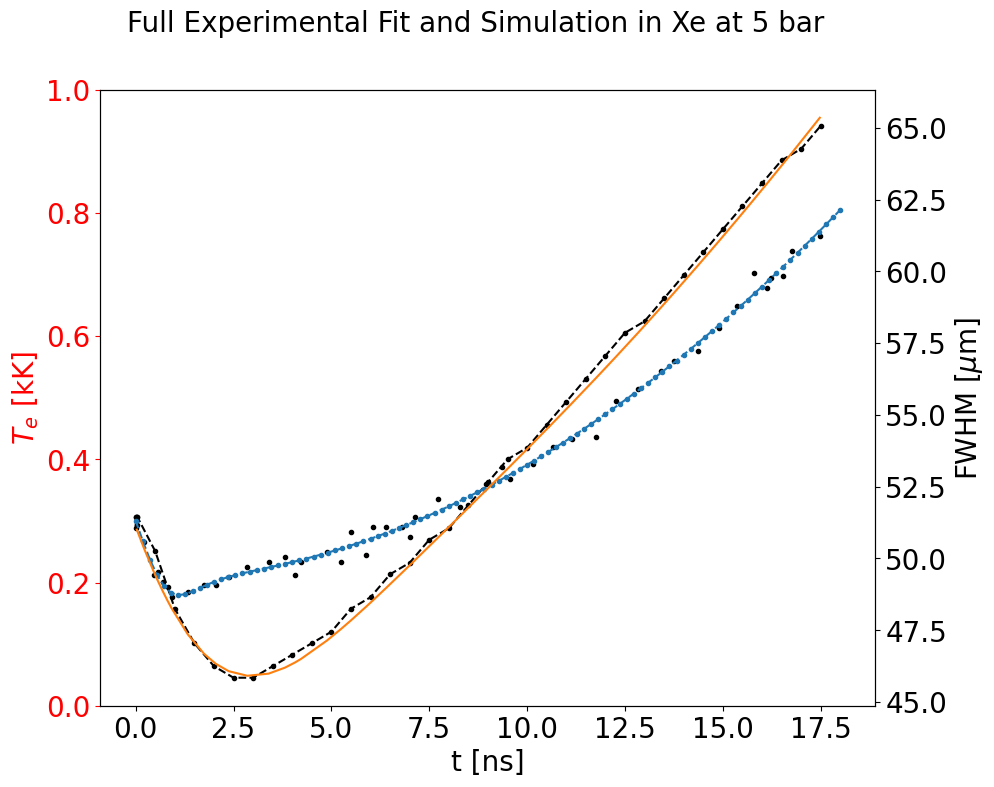

In [310]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle("Full Experimental Fit and Simulation in Xe at 5 bar", fontsize=20)

# ax.plot(np.array(FWHM_t_list[:143])*1e9, np.array(Te_fit_list)/1e3,'--', color='r', )
# ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'r.', label='Experiment Data')

ax.set_ylabel(r'$T_e$ [kK]', fontsize=20, color='r')
ax.set_xlabel('t [ns]', fontsize=20)
# ax.set_xlim(0,12)

# ax.set_ylim(40,60)
ax.tick_params(labelsize=20)
ax.tick_params(axis='y',color='r', labelcolor='r')

ax2 = ax.twinx()
ax2.plot(np.array(FWHM_t_list)*1e9, np.array(FWHM_list)*1e6,'--.k')
dense_t_list = np.linspace(0,18,num=100)
ax2.plot(Xe_FWHM_data['t[ns]'], Xe_FWHM_data['FWHM[μm]'], 'k.', label='Experiment Data')
ax2.plot(dense_t_list, FWHM_fit_form(dense_t_list,*FWHM_vals),'--.')
ax2.plot(Xe_FWHM_data['t[ns]'], FWHM_fit_form(Xe_FWHM_data['t[ns]'],
                        47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2))
# ax2.plot(np.array(FWHM_t_list)*1e9, np.array(FWHM_list)*1e6-FWHM_adiabatic_fit_form(np.array(FWHM_t_list)*1e9,*FWHM_adiabatic_vals))



ax2.set_ylabel('FWHM [$\mu$m]', fontsize=20)
ax2.tick_params(labelsize=20)
# ax.set_xscale('log')
# ax2.set_yscale('log')
# ax.set_xlim(0,3)

In [313]:


def T_fit_form(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

def T_DIHfit_form(t, Te_0, d, τei):
    Ti_0 = Ti_initial
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

def FWHM_adiabatic_fit_form(t, FWHM_0, vf):
    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) 

def FWHM_fit_form(t, FWHM_0, vf, a, b, t0, c, d):
    return np.sqrt(FWHM_0**2 + vf**2*t**2 ) + (1/(1+np.exp( a*(t-t0))))* (b*t+ c) + d



Te0_fit, Ti0_fit, d_fit, τei_fit = curve_fit(T_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] )[0]
# FWHM_vals = curve_fit(FWHM_fit_form, Xe_FWHM_data['t[ns]'], Xe_FWHM_data['FWHM[μm]'] ,maxfev=int(1e4),p0=[47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2])[0]
FWHM_vals = least_squares(FWHM_fit_form, np.array(FWHM_t_list)*1e9,np.array(FWHM_list)*1e6 ,maxfev=int(1e5),p0=(47.79699697,  2.534726490,  0.5,  -5, 1, 5, 0.2))[0]
FWHM_adiabatic_vals = curve_fit(FWHM_adiabatic_fit_form, np.array(FWHM_t_list)*1e9,np.array(FWHM_list)*1e6 ,maxfev=int(1e4))[0]
FWHM_adiabatic_vals, FWHM_vals

TypeError: least_squares() got an unexpected keyword argument 'maxfev'

In [159]:
def plot_bulk_temperature(ttm,ax, plot_times = None, title=''):
    bulk_Tes = np.array(Te_fit_list)

    ti_1, ti_2 = -40, -39

    dT_dt  = (bulk_Tes[ti_2] - bulk_Tes[ti_1])/(FWHM_t_list[ti_2] - FWHM_t_list[ti_1])

#     T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))


    ax.plot(np.array(ttm.t_saved_list)*1e9, bulk_Tes*1e-3,label=r"$T_e$ (bulk)")
#     ax.plot(np.array(ttm.t_list)*1e9, bulk_Tis*1e-3,label=r"$T_i$ (bulk)")
#     ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k',label='Linear Diffusion line')
#     ax.plot(np.array(ttm.t_list)*1e9, T_av*1e-3,'-k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0]*1e-3))
    
#     bulk_T_exp_fit = (Te_initial + Ti_initial)/2 - 0.5*120*1e9*ttm.t_list + (Te_initial - Ti_initial)/2 * np.exp(-ttm.t_list/(1470e-12))
#     print(bulk_T_exp_fit)
#     ax.plot(np.array(ttm.t_saved_list)*1e9, T_fit_form(np.array(ttm.t_saved_list)*1e9, Te0_fit, Ti0_fit, d_fit, τei_fit),'r--' ,label="Experiment Fit")
#     ax.plot(np.array(ttm.t_saved_list)*1e9, T_DIHfit_form(np.array(ttm.t_saved_list)*1e9, Te0_fit, d_fit, τei_fit),'r-.' ,label="Experiment DIH fixed Fit")
    ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'r-', label='Experiment Data')
    # Thermalization Text
    thermalization_text = r'$\tau_{th}$' + ' = {0:.1f} [ps] (exp 1470 ps)'.format(ttm.experiment.τei_Equilibration*1e12)
    thermalization_head_x_pos = 0.5* ttm.experiment.τei_Equilibration*1e9
    thermalization_head_y_pos = bulk_Tes[np.argmin(np.abs(ttm.t_list-thermalization_head_x_pos*1e-9))]*1e-3
    
    thermalization_arrow_head_coords = (thermalization_head_x_pos, thermalization_head_y_pos )
    ax.annotate(thermalization_text, xy=thermalization_arrow_head_coords, xycoords='data',
                xytext=(150, 60), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))

    # Diffusion Text
    diffusion_text = 'Diffusion Estimate:\n dT/dt={0:.2f} [K/ns] (exp -120 K/ns)'.format(dT_dt*1e-9)
    diffusion_head_x_pos = 0.5*ttm.tmax*1e9
    diffusion_head_y_pos = 0.1 + bulk_Tes[np.argmin(np.abs(ttm.t_list-diffusion_head_x_pos*1e-9))]*1e-3
    
    diffusion_arrow_head_coords = (diffusion_head_x_pos, diffusion_head_y_pos )
    ax.annotate(diffusion_text, xy=diffusion_arrow_head_coords, xycoords='data',
                xytext=(60, 30), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    fit_string =  (r"My fit: $τ_{{ei}}$ = {0:.1f} [ps]".format(τei_fit*1e3) + '\n'+
                   r" $dT_e/dt$ = -{0:.1f} K/ns".format(d_fit*1e3) + '\n' +
                   r" $T^{{\rm init}}_e$ = {0:.2f} [kK]".format(Te0_fit) + '\n' +
                   r" $T^{{\rm init}}_i$ = {0:.2f} [kK]".format(Ti0_fit)

                  )
    ax.text(0.5, 0.95, fit_string, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)



    # Plot settings
    ax.set_xlabel(r"Time [ns]", fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(-0.1,ttm.tmax*1e9)
    ax.set_ylim(10,17)

    ax.set_title(title,fontsize=20)
    ax.legend(fontsize=14)
    ax.grid(alpha=0.3)


ValueError: x and y must have same first dimension, but have shapes (1799,) and (40,)

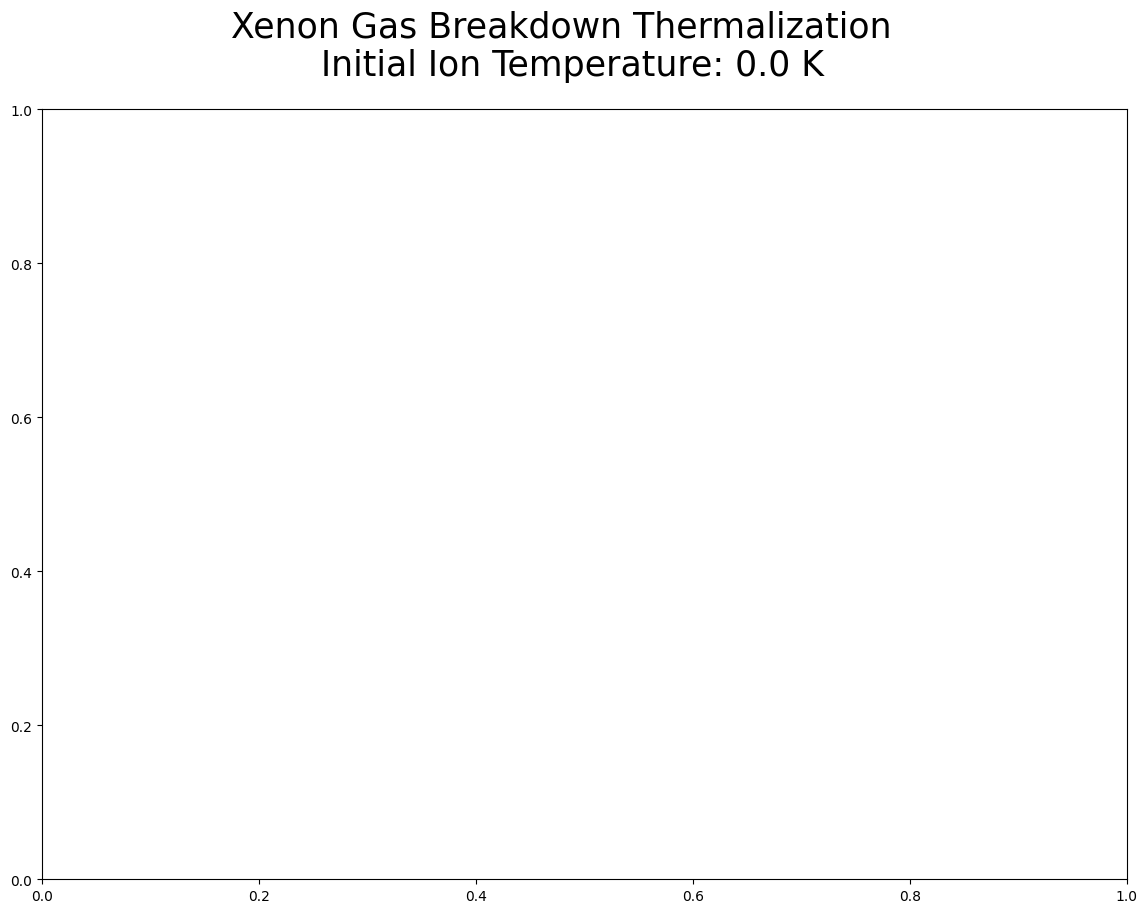

In [160]:
fig, ax = plt.subplots(1,1, figsize=(14,10),facecolor='w')
ax = np.array([ax])
fig.suptitle('Xenon Gas Breakdown Thermalization \n Initial Ion Temperature: {0:.1f} K'.format(Ti_initial),fontsize=25)

plot_bulk_temperature(ttm, ax[0], title='JT GMS')
fig.tight_layout()